# CREACIÓN DEL DATAMART ANALÍTICO

Actividades:

1. Acceder a la base de datos
2. Importar los datos como dataframes de Pandas
3. Realizar la calidad de datos
4. Crear el datamart analítico
5. Guardarlo como una tabla en la base de datos para no tener que repetir el proceso

## SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

In [4]:
pd.reset_option('display.max_rows')

## IMPORTACION DE DATOS

### Datos internos

Crear la conexión a la base de datos

In [2]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

In [3]:
from sqlalchemy import inspect
insp = inspect(con)
tablas = insp.get_table_names()
tablas

['listings', 'listings_det']

Cargar las tablas

In [5]:
listings = pd.read_sql('listings', con)
listings_det = pd.read_sql('listings_det', con)

### Datos Externos

En nuestros datos no tenemos el precio de compra de un inmueble, pero es una de las palancas principales.

Por tanto vamos a buscar esos datos de forma externa.

En esta página tenemos la info que necesitamos: https://mudafy.com.mx/d/valor-metro-cuadrado-cdmx (información a Septiembre de 2024)

Cargamos los datos.

In [6]:
precio_m2 = pd.read_csv('../Datos/precios_mudafy.csv') \
    .rename(columns = {'Alcaldía':'alcaldia','Precio /m2 (MXN)':'precio_m2'})
precio_m2

,alcaldia,precio_m2
0,Álvaro Obregón,$48.367
1,Azcapotzalco,$33.667
2,Benito Juárez,$47.383
3,Coyoacán,$41.429
4,Cuajimalpa de Morelos,$51.212
5,Cuauhtémoc,$57.859
6,Gustavo A. Madero,$28.632
7,Iztacalco,$30.511
8,Iztapalapa,$21.937
9,La Magdalena Contreras,$36.292


Limpiamos el precio:
    
1. quitando la unidad
2. quitando los puntos de separador de miles
3. cambiando el tipo a entero

In [7]:
precio_m2['precio_m2'] = precio_m2.precio_m2.str.replace('$','').str.replace('.','',regex=False).astype('int')
precio_m2

,alcaldia,precio_m2
0,Álvaro Obregón,48367
1,Azcapotzalco,33667
2,Benito Juárez,47383
3,Coyoacán,41429
4,Cuajimalpa de Morelos,51212
5,Cuauhtémoc,57859
6,Gustavo A. Madero,28632
7,Iztacalco,30511
8,Iztapalapa,21937
9,La Magdalena Contreras,36292


## CALIDAD DE DATOS

### Tabla listings

#### Visión general

In [8]:
listings.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,35797,Villa Dante,153786,Dici,NaN,Cuajimalpa de Morelos,19.38283,-99.27178,Entire home/apt,3663.0,1,0,None,NaN,1,363,0,NaN
1,1,898633,City SkyLine View from 1 Bedroom Apt in CDMX,4796027,Marco,NaN,Cuauhtémoc,19.42063,-99.16586,Entire home/apt,1652.0,3,56,2024-04-17,0.41,3,262,3,NaN
2,2,44616,CONDESA HAUS B&B,196253,Fernando,NaN,Cuauhtémoc,19.41162,-99.17794,Entire home/apt,18000.0,1,64,2023-03-26,0.42,13,364,0,NaN
3,3,913084,15 blocks from Paseo de la Reforma,4647293,Martina,NaN,Miguel Hidalgo,19.43956,-99.17263,Entire home/apt,814.0,2,161,2024-05-21,1.19,1,236,6,NaN
4,4,67703,"2 bedroom apt. deco bldg, Condesa",334451,Nicholas,NaN,Cuauhtémoc,19.41152,-99.16857,Entire home/apt,1923.0,2,49,2024-05-05,0.32,2,361,4,NaN


In [9]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26536 entries, 0 to 26535
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           26536 non-null  int64  
 1   id                              26536 non-null  int64  
 2   name                            26536 non-null  object 
 3   host_id                         26536 non-null  int64  
 4   host_name                       26536 non-null  object 
 5   neighbourhood_group             0 non-null      float64
 6   neighbourhood                   26536 non-null  object 
 7   latitude                        26536 non-null  float64
 8   longitude                       26536 non-null  float64
 9   room_type                       26536 non-null  object 
 10  price                           23338 non-null  float64
 11  minimum_nights                  26536 non-null  int64  
 12  number_of_reviews               

#### Variables y tipos

Vamos a eliminar aquellas variables que no necesitaremos directamente para nuestros objetivos.

In [10]:
a_eliminar = ['index',
              'host_name',
              'number_of_reviews',
              'last_review',
              'reviews_per_month',
              'number_of_reviews_ltm',
              'license',
              'neighbourhood_group' 
             ]

listings.drop(columns = a_eliminar, inplace=True)

listings

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,35797,Villa Dante,153786,Cuajimalpa de Morelos,19.382830,-99.271780,Entire home/apt,3663.0,1,1,363
1,898633,City SkyLine View from 1 Bedroom Apt in CDMX,4796027,Cuauhtémoc,19.420630,-99.165860,Entire home/apt,1652.0,3,3,262
2,44616,CONDESA HAUS B&B,196253,Cuauhtémoc,19.411620,-99.177940,Entire home/apt,18000.0,1,13,364
3,913084,15 blocks from Paseo de la Reforma,4647293,Miguel Hidalgo,19.439560,-99.172630,Entire home/apt,814.0,2,1,236
4,67703,"2 bedroom apt. deco bldg, Condesa",334451,Cuauhtémoc,19.411520,-99.168570,Entire home/apt,1923.0,2,2,361
...,...,...,...,...,...,...,...,...,...,...,...
26531,1187191423076770832,¡Crystal! - 7BR Fantastic! In heart of Roma,19255745,Cuauhtémoc,19.404546,-99.168252,Entire home/apt,7850.0,2,8,365
26532,1187248376951514656,Iconic Suite | Terrace | View !,7681206,Cuauhtémoc,19.420567,-99.166263,Entire home/apt,1478.0,1,11,363
26533,1187269835146549014,Acogedor y moderno depa en la Condesa,50951150,Cuauhtémoc,19.408648,-99.170992,Entire home/apt,936.0,2,1,363
26534,1187283698786191137,Estudio con amplia terraza,147254250,Cuauhtémoc,19.412367,-99.166447,Entire home/apt,768.0,1,3,254


Revisamos los tipos de variable

In [11]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26536 entries, 0 to 26535
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              26536 non-null  int64  
 1   name                            26536 non-null  object 
 2   host_id                         26536 non-null  int64  
 3   neighbourhood                   26536 non-null  object 
 4   latitude                        26536 non-null  float64
 5   longitude                       26536 non-null  float64
 6   room_type                       26536 non-null  object 
 7   price                           23338 non-null  float64
 8   minimum_nights                  26536 non-null  int64  
 9   calculated_host_listings_count  26536 non-null  int64  
 10  availability_365                26536 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.2+ MB


Pasar algunas variables de tipo objeto (neighbourhood, room_type) a categóricas.

In [12]:
for variable in ['neighbourhood','room_type']:
    listings[variable] = listings[variable].astype('category')

Comprobamos

In [13]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26536 entries, 0 to 26535
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              26536 non-null  int64   
 1   name                            26536 non-null  object  
 2   host_id                         26536 non-null  int64   
 3   neighbourhood                   26536 non-null  category
 4   latitude                        26536 non-null  float64 
 5   longitude                       26536 non-null  float64 
 6   room_type                       26536 non-null  category
 7   price                           23338 non-null  float64 
 8   minimum_nights                  26536 non-null  int64   
 9   calculated_host_listings_count  26536 non-null  int64   
 10  availability_365                26536 non-null  int64   
dtypes: category(2), float64(3), int64(5), object(1)
memory usage: 1.9+ MB


#### Análisis de nulos

In [14]:
listings[listings.price.isna()].head(50)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
9,131610,MARIA DEL ALMA,647454,Coyoacán,19.354160,-99.164880,Private room,NaN,1,3,0
16,187030,Spacious apt with the best rooftop in Condesa,899360,Cuauhtémoc,19.410570,-99.177300,Entire home/apt,NaN,4,6,0
17,187745,Extraordinarily Spacious Apt. in Condesa,899360,Cuauhtémoc,19.410570,-99.177300,Entire home/apt,NaN,14,6,0
22,1087636,Apartment at south of Mexico city,5975456,Coyoacán,19.305230,-99.183560,Private room,NaN,1,1,362
33,1211383,Room & bathroom in great house!,212109,Coyoacán,19.355000,-99.161810,Private room,NaN,5,3,0
37,276504,High End Condo with golf package,1444589,Iztacalco,19.380610,-99.127290,Entire home/apt,NaN,7,1,0
39,281134,COOL PENT HOUSE APARTMENT @CONDESA,196253,Cuauhtémoc,19.411080,-99.176340,Hotel room,NaN,1,13,330
43,291804,A nice room with great location,1511568,Benito Juárez,19.363050,-99.154120,Private room,NaN,2,1,0
46,298873,"The ""home"" feeling in Mexico City!",1539548,Cuauhtémoc,19.433580,-99.144520,Entire home/apt,NaN,3,1,0
51,325812,"Confortable private room, downtown Mexico City.",1666388,Cuauhtémoc,19.433190,-99.146650,Private room,NaN,4,1,0


Imputación de nulos en la variable 'price' por la media. La media correspondiente a cada imputación se calcula a partir de una segmentación por 'neighbourhood' y 'room_type'

In [15]:
price_avg_by_group = listings.groupby(['neighbourhood', 'room_type'], observed = False)['price'].mean()

Revisamos los resultados de la segmentación:

In [16]:
price_avg_by_group

neighbourhood   room_type      
Azcapotzalco    Entire home/apt     900.324607
                Hotel room                 NaN
                Private room        445.048780
                Shared room                NaN
Benito Juárez   Entire home/apt    1309.241692
                                      ...     
Xochimilco      Shared room         391.333333
Álvaro Obregón  Entire home/apt    1512.131481
                Hotel room         1416.625000
                Private room        751.358127
                Shared room        1098.222222
Name: price, Length: 64, dtype: float64

Volvemos a revisar el total de registros nulos que tenemos:

In [17]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26536 entries, 0 to 26535
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              26536 non-null  int64   
 1   name                            26536 non-null  object  
 2   host_id                         26536 non-null  int64   
 3   neighbourhood                   26536 non-null  category
 4   latitude                        26536 non-null  float64 
 5   longitude                       26536 non-null  float64 
 6   room_type                       26536 non-null  category
 7   price                           23338 non-null  float64 
 8   minimum_nights                  26536 non-null  int64   
 9   calculated_host_listings_count  26536 non-null  int64   
 10  availability_365                26536 non-null  int64   
dtypes: category(2), float64(3), int64(5), object(1)
memory usage: 1.9+ MB


Algunas consultas que nos serán útiles para culminar el análisis de nulos:

In [18]:
listings.neighbourhood.value_counts()

neighbourhood
Cuauhtémoc                12192
Miguel Hidalgo             4602
Benito Juárez              3137
Coyoacán                   1714
Álvaro Obregón             1093
Tlalpan                     798
Venustiano Carranza         730
Gustavo A. Madero           517
Cuajimalpa de Morelos       443
Iztacalco                   384
Azcapotzalco                304
Iztapalapa                  264
Xochimilco                  141
La Magdalena Contreras      139
Tláhuac                      49
Milpa Alta                   29
Name: count, dtype: int64

In [19]:
listings.room_type.value_counts()

room_type
Entire home/apt    17432
Private room        8581
Shared room          401
Hotel room           122
Name: count, dtype: int64

In [20]:
# Contar cuántos registros hay en cada grupo de neighbourhood y room_type
count_by_group = listings.groupby(['neighbourhood', 'room_type'], observed=False)['price'].count()
print(count_by_group)

neighbourhood   room_type      
Azcapotzalco    Entire home/apt     191
                Hotel room            0
                Private room         82
                Shared room           0
Benito Juárez   Entire home/apt    1655
                                   ... 
Xochimilco      Shared room           3
Álvaro Obregón  Entire home/apt     540
                Hotel room            8
                Private room        363
                Shared room           9
Name: price, Length: 64, dtype: int64


In [21]:
count_by_group_df= pd.DataFrame(count_by_group)

In [22]:
pd.set_option('display.max_rows', None)

In [23]:
count_by_group_df.reset_index().head(64)

,neighbourhood,room_type,price
0,Azcapotzalco,Entire home/apt,191
1,Azcapotzalco,Hotel room,0
2,Azcapotzalco,Private room,82
3,Azcapotzalco,Shared room,0
4,Benito Juárez,Entire home/apt,1655
5,Benito Juárez,Hotel room,5
6,Benito Juárez,Private room,1041
7,Benito Juárez,Shared room,37
8,Coyoacán,Entire home/apt,739
9,Coyoacán,Hotel room,1


In [24]:
pd.reset_option('display.max_rows')

In [25]:
#Imputación de nulos
listings['price'] = listings.apply(lambda row: price_avg_by_group[row['neighbourhood'], row['room_type']] 
                       if pd.isnull(row['price']) else row['price'], axis=1)

In [26]:
#Revisión de nulos post-imputación
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26536 entries, 0 to 26535
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              26536 non-null  int64   
 1   name                            26536 non-null  object  
 2   host_id                         26536 non-null  int64   
 3   neighbourhood                   26536 non-null  category
 4   latitude                        26536 non-null  float64 
 5   longitude                       26536 non-null  float64 
 6   room_type                       26536 non-null  category
 7   price                           26534 non-null  float64 
 8   minimum_nights                  26536 non-null  int64   
 9   calculated_host_listings_count  26536 non-null  int64   
 10  availability_365                26536 non-null  int64   
dtypes: category(2), float64(3), int64(5), object(1)
memory usage: 1.9+ MB


Encontramos que dos registros no fueron imputados, podemos descartarlos pues, al ser dos registros, no afecta a nuestro análisis. Lo siguiente es una pequeña exploración para saber porqué no fueron imputados.

In [27]:
#Identificación de los registros que no se imputaron
# Filtrar las filas donde 'price' es nulo
listings[listings.price.isna()].head()

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
4048,27656261,Habitación muy cómoda y segura.En casa de 3 pi...,208712604,La Magdalena Contreras,19.30564,-99.26347,Shared room,NaN,1,1,0
6446,38219708,Inspirando a crear!,161595231,Milpa Alta,19.19653,-99.02629,Shared room,NaN,1,1,0


In [28]:
listings.loc[6446]

id                                           38219708
name                              Inspirando a crear!
host_id                                     161595231
neighbourhood                              Milpa Alta
latitude                                     19.19653
longitude                                   -99.02629
room_type                                 Shared room
price                                             NaN
minimum_nights                                      1
calculated_host_listings_count                      1
availability_365                                    0
Name: 6446, dtype: object

In [29]:
listings.loc[4048]

id                                                                         27656261
name                              Habitación muy cómoda y segura.En casa de 3 pi...
host_id                                                                   208712604
neighbourhood                                                La Magdalena Contreras
latitude                                                                   19.30564
longitude                                                                 -99.26347
room_type                                                               Shared room
price                                                                           NaN
minimum_nights                                                                    1
calculated_host_listings_count                                                    1
availability_365                                                                  0
Name: 4048, dtype: object

Lo que encontramos es que no se realizó la imputación de nulos en tales registros por la naturaleza de la obtención de las medias para imputar, esto es, la segmentación por dos variables. No contamos con registros compartidos de 'La Magdalena Contreras' y 'shared room', de la misma manera con 'Milpa Alta' y 'shared room' para obtener la media e imputar en los registros que tengan estas dos combinaciones. Esta misma situación ocurre con más combinaciones pero no afecta a nuestra imputación porque no hay registros nulos que tengan tales características.

Si quisiéramos imputar los dos registros deberíamos hacer una segmentación ahora comparando los otros shared room de los otros 'neighbourhoods' y también comparar con los registros del mismo neighbourhood. Eso sólo sería un malgasto de recursos y tiempo, puesto que son dos registros, además de que estaríamos introduciendo más error a nuestros cálculos de manera innecesaria.

In [30]:
listings.dropna(inplace = True)

In [31]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26534 entries, 0 to 26535
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              26534 non-null  int64   
 1   name                            26534 non-null  object  
 2   host_id                         26534 non-null  int64   
 3   neighbourhood                   26534 non-null  category
 4   latitude                        26534 non-null  float64 
 5   longitude                       26534 non-null  float64 
 6   room_type                       26534 non-null  category
 7   price                           26534 non-null  float64 
 8   minimum_nights                  26534 non-null  int64   
 9   calculated_host_listings_count  26534 non-null  int64   
 10  availability_365                26534 non-null  int64   
dtypes: category(2), float64(3), int64(5), object(1)
memory usage: 2.1+ MB


In [32]:
listings

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,35797,Villa Dante,153786,Cuajimalpa de Morelos,19.382830,-99.271780,Entire home/apt,3663.0,1,1,363
1,898633,City SkyLine View from 1 Bedroom Apt in CDMX,4796027,Cuauhtémoc,19.420630,-99.165860,Entire home/apt,1652.0,3,3,262
2,44616,CONDESA HAUS B&B,196253,Cuauhtémoc,19.411620,-99.177940,Entire home/apt,18000.0,1,13,364
3,913084,15 blocks from Paseo de la Reforma,4647293,Miguel Hidalgo,19.439560,-99.172630,Entire home/apt,814.0,2,1,236
4,67703,"2 bedroom apt. deco bldg, Condesa",334451,Cuauhtémoc,19.411520,-99.168570,Entire home/apt,1923.0,2,2,361
...,...,...,...,...,...,...,...,...,...,...,...
26531,1187191423076770832,¡Crystal! - 7BR Fantastic! In heart of Roma,19255745,Cuauhtémoc,19.404546,-99.168252,Entire home/apt,7850.0,2,8,365
26532,1187248376951514656,Iconic Suite | Terrace | View !,7681206,Cuauhtémoc,19.420567,-99.166263,Entire home/apt,1478.0,1,11,363
26533,1187269835146549014,Acogedor y moderno depa en la Condesa,50951150,Cuauhtémoc,19.408648,-99.170992,Entire home/apt,936.0,2,1,363
26534,1187283698786191137,Estudio con amplia terraza,147254250,Cuauhtémoc,19.412367,-99.166447,Entire home/apt,768.0,1,3,254


#### Análisis de duplicados

Comprobamos si hay algún registro duplicado

In [33]:
listings.duplicated().sum()

0

#### Análisis de variables categóricas

Vamos a analizar los valores y las frecuencias de las variables categóricas

In [34]:
listings.neighbourhood.value_counts()

neighbourhood
Cuauhtémoc                12192
Miguel Hidalgo             4602
Benito Juárez              3137
Coyoacán                   1714
Álvaro Obregón             1093
Tlalpan                     798
Venustiano Carranza         730
Gustavo A. Madero           517
Cuajimalpa de Morelos       443
Iztacalco                   384
Azcapotzalco                304
Iztapalapa                  264
Xochimilco                  141
La Magdalena Contreras      138
Tláhuac                      49
Milpa Alta                   28
Name: count, dtype: int64

In [35]:
listings.room_type.value_counts()

room_type
Entire home/apt    17432
Private room        8581
Shared room          399
Hotel room           122
Name: count, dtype: int64

Vemos que hay hoteles. Nuestra empresa no se plantea comprar hoteles, así que tenemos que eliminar estos registros.

In [36]:
listings = listings.loc[listings.room_type != 'Hotel room']

In [37]:
listings.room_type.value_counts()

room_type
Entire home/apt    17432
Private room        8581
Shared room          399
Hotel room             0
Name: count, dtype: int64

In [38]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26412 entries, 0 to 26535
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              26412 non-null  int64   
 1   name                            26412 non-null  object  
 2   host_id                         26412 non-null  int64   
 3   neighbourhood                   26412 non-null  category
 4   latitude                        26412 non-null  float64 
 5   longitude                       26412 non-null  float64 
 6   room_type                       26412 non-null  category
 7   price                           26412 non-null  float64 
 8   minimum_nights                  26412 non-null  int64   
 9   calculated_host_listings_count  26412 non-null  int64   
 10  availability_365                26412 non-null  int64   
dtypes: category(2), float64(3), int64(5), object(1)
memory usage: 2.1+ MB


#### Análisis de variables numéricas

De las variables numéricas tiene sentido analizar desde price hasta availability_365, esto es, desde las posiciones de columnas de la 7 a la 11

In [39]:
listings.iloc[:,7:11].describe().T

,count,mean,std,min,25%,50%,75%,max
price,26412.0,1438.946380,3921.099893,105.0,646.75,1000.0,1590.0,416684.0
minimum_nights,26412.0,4.713880,24.209111,1.0,1.00,2.0,2.0,1125.0
calculated_host_listings_count,26412.0,17.213274,43.387855,1.0,1.00,3.0,11.0,267.0
availability_365,26412.0,224.055505,124.673652,0.0,116.00,261.0,345.0,365.0


Conclusiones:

* En el precio hay que revisar mínimos y máximos
* En minimum_nights hay que revisar los máximos
* En calculated_host_listings_count hay que revisar los máximos

Revisamos mínimos y máximos en el precio

<Axes: ylabel='Density'>

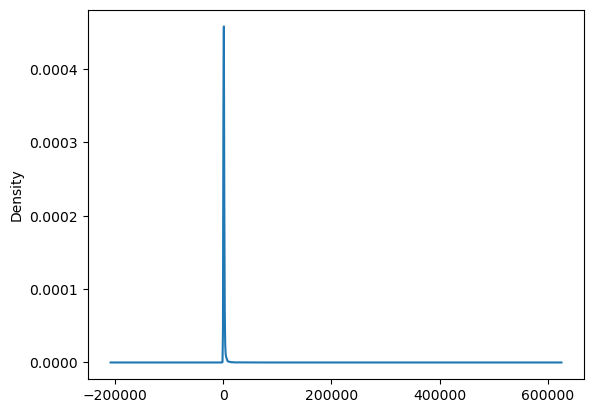

In [40]:
listings.price.plot.kde()

Revisamos los máximos

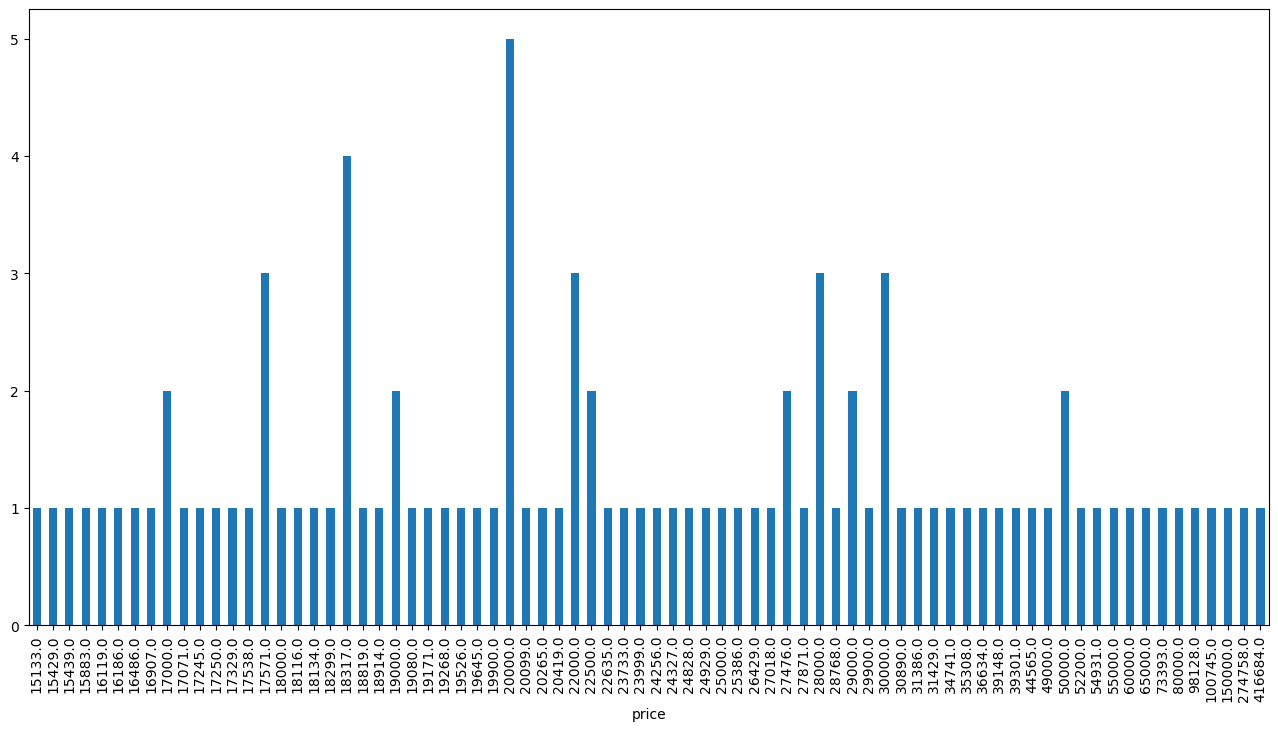

In [41]:
plt.figure(figsize=(16,8))
listings.price.loc[listings.price > 15000].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

In [42]:
registro = listings[listings['price'] == 416684].iloc[0]  # Primer registro coincidente
print(registro)

id                                                                 29075148
name                              Cozy B&B Roma Norte Room 1 with breakfast
host_id                                                           176362944
neighbourhood                                                    Cuauhtémoc
latitude                                                            19.4239
longitude                                                          -99.1562
room_type                                                      Private room
price                                                              416684.0
minimum_nights                                                            1
calculated_host_listings_count                                            3
availability_365                                                        276
Name: 4296, dtype: object


In [43]:
registro = listings[listings['host_id'] == 176362944]
registro

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
3359,24020942,Cozy B&B Roma Norte Room 2 con desayuno,176362944,Cuauhtémoc,19.42395,-99.15656,Private room,819.0,2,3,264
4296,29075148,Cozy B&B Roma Norte Room 1 with breakfast,176362944,Cuauhtémoc,19.42390,-99.15620,Private room,416684.0,1,3,276
21575,1006549472336129024,Cozy BnB CDMX Roma Norte,176362944,Cuauhtémoc,19.42479,-99.15535,Private room,823.0,1,3,234


Conclusión: 
    
* Encontramos un dato atípico y muy elevado de renta por noche en un registro. También encontramos que el mismo dueño tiene dos rentas más disponibles. Al investigar los otros dos registros encontramos que el registro con el valor atípico (de casi medio millón de pesos mexicanos por noche) es la habitación 1 de lo que parece ser un conjunto de tres B&B del mismo dueño. Al tratarse de B&B y de que están situados en la misma parte de la ciudad (esto comprobable por las coordenadas de los registros), con el fin de no eliminar el registro, se toma la decisión de imputar el valor de la renta del registro atípico por el mismo que tiene el otro registro (la habitación número 2)

In [44]:
listings.loc[4296, 'price'] = 819 # Cambiar el valor en la fila

In [45]:
#Comprobamos el cambio
registro = listings[listings['host_id'] == 176362944]
registro

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
3359,24020942,Cozy B&B Roma Norte Room 2 con desayuno,176362944,Cuauhtémoc,19.42395,-99.15656,Private room,819.0,2,3,264
4296,29075148,Cozy B&B Roma Norte Room 1 with breakfast,176362944,Cuauhtémoc,19.42390,-99.15620,Private room,819.0,1,3,276
21575,1006549472336129024,Cozy BnB CDMX Roma Norte,176362944,Cuauhtémoc,19.42479,-99.15535,Private room,823.0,1,3,234


Revisamos los valores más bajos

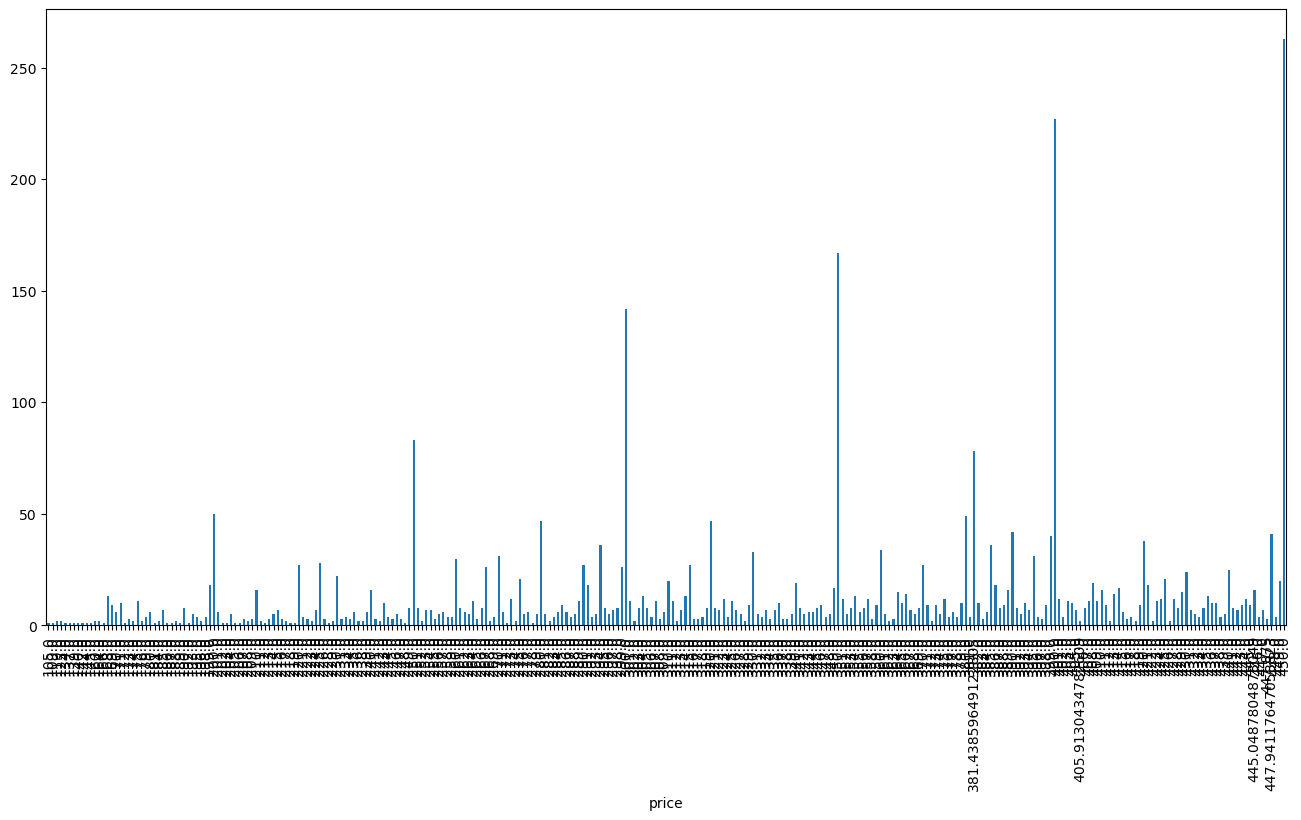

In [46]:
plt.figure(figsize=(16,8))
listings.price.loc[listings.price <= 450].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Conclusión: 
    
* Hay un pico en 400 pesos, y parece que por debajo de esa cantidad sería difícil obtener rentabilidad, así que vamos a descartar los inmuebles que se alquilan por debajo de 400 pesos

In [47]:
listings = listings.loc[listings.price > 399]
listings

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,35797,Villa Dante,153786,Cuajimalpa de Morelos,19.382830,-99.271780,Entire home/apt,3663.0,1,1,363
1,898633,City SkyLine View from 1 Bedroom Apt in CDMX,4796027,Cuauhtémoc,19.420630,-99.165860,Entire home/apt,1652.0,3,3,262
2,44616,CONDESA HAUS B&B,196253,Cuauhtémoc,19.411620,-99.177940,Entire home/apt,18000.0,1,13,364
3,913084,15 blocks from Paseo de la Reforma,4647293,Miguel Hidalgo,19.439560,-99.172630,Entire home/apt,814.0,2,1,236
4,67703,"2 bedroom apt. deco bldg, Condesa",334451,Cuauhtémoc,19.411520,-99.168570,Entire home/apt,1923.0,2,2,361
...,...,...,...,...,...,...,...,...,...,...,...
26531,1187191423076770832,¡Crystal! - 7BR Fantastic! In heart of Roma,19255745,Cuauhtémoc,19.404546,-99.168252,Entire home/apt,7850.0,2,8,365
26532,1187248376951514656,Iconic Suite | Terrace | View !,7681206,Cuauhtémoc,19.420567,-99.166263,Entire home/apt,1478.0,1,11,363
26533,1187269835146549014,Acogedor y moderno depa en la Condesa,50951150,Cuauhtémoc,19.408648,-99.170992,Entire home/apt,936.0,2,1,363
26534,1187283698786191137,Estudio con amplia terraza,147254250,Cuauhtémoc,19.412367,-99.166447,Entire home/apt,768.0,1,3,254


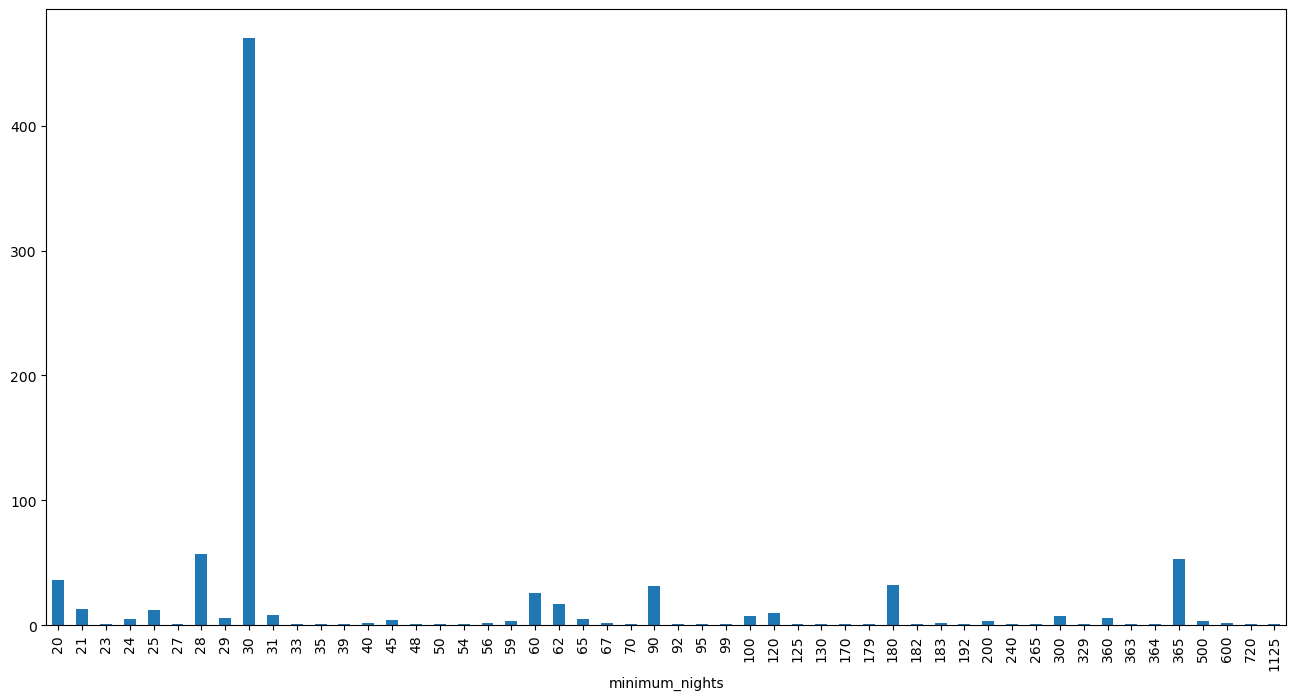

In [48]:
plt.figure(figsize=(16,8))
listings.minimum_nights.loc[listings.minimum_nights >= 20].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Ya que el objetivo del proyecto es identificar inmuebles para alquilar a turistas, no parece muy atractivo adquirir inmuebles que tengan un mínimo de días de renta de más de 30 días. Sin embargo, al comprarlos, nosotros podemos cambiar este requisito, de manera que lo que más nos importa es conseguir propiedades a menor precio y en las que se pueda cobrar más renta por noche.

Conclusión:
* de momento no vamos a tocar esta variable.

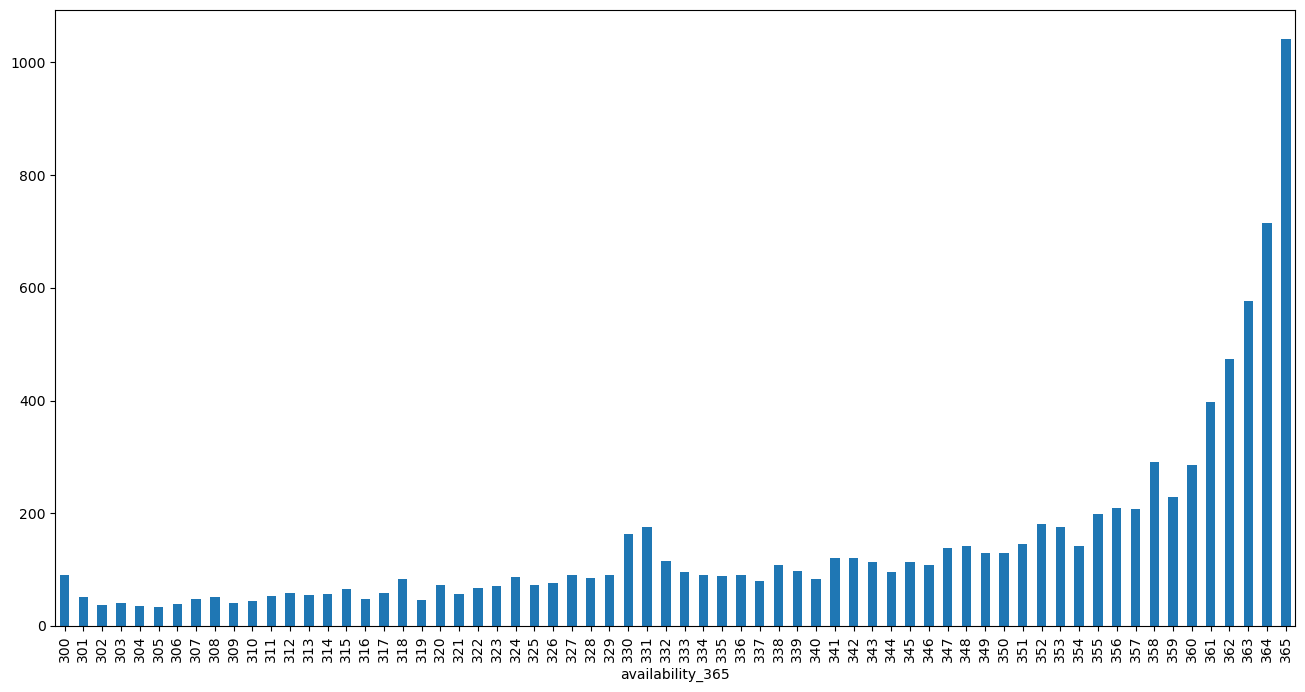

In [49]:
plt.figure(figsize=(16,8))
listings.availability_365.loc[listings.availability_365 >= 300].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

No parece haber nada atípico en esta variable, por lo tanto no haremos nada con ella.

### Tabla listings_det

#### Visión general

In [50]:
listings_det.head()

,index,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,898633,https://www.airbnb.com/rooms/898633,20240627045222,2024-06-28,city scrape,City SkyLine View from 1 Bedroom Apt in CDMX,The LOCATION is undoubtedly THE BIG advantage ...,The hipster Roma neighborhood embodies a color...,https://a0.muscache.com/pictures/ba75b1c1-cb02...,...,4.96,4.93,4.91,NaN,f,3,2,1,0,0.41
1,1,35797,https://www.airbnb.com/rooms/35797,20240627045222,2024-06-27,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Mall, Interloma Park and the Lion Des...",https://a0.muscache.com/pictures/f395ab78-1185...,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
2,2,44616,https://www.airbnb.com/rooms/44616,20240627045222,2024-06-28,city scrape,CONDESA HAUS B&B,A new concept of hosting in mexico through a b...,None,https://a0.muscache.com/pictures/251410/ec75fe...,...,4.78,4.98,4.48,NaN,f,13,4,2,0,0.42
3,3,913084,https://www.airbnb.com/rooms/913084,20240627045222,2024-06-28,city scrape,15 blocks from Paseo de la Reforma,None,"It borders the old and traditional San Rafael,...",https://a0.muscache.com/pictures/16663562/7bed...,...,4.93,4.46,4.75,NaN,t,1,1,0,0,1.19
4,4,67703,https://www.airbnb.com/rooms/67703,20240627045222,2024-06-28,city scrape,"2 bedroom apt. deco bldg, Condesa","Comfortably furnished, sunny, 2 bedroom apt., ...",None,https://a0.muscache.com/pictures/3281720/6f078...,...,4.92,4.98,4.91,NaN,f,2,2,0,0,0.32


In [51]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26536 entries, 0 to 26535
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         26536 non-null  int64  
 1   id                                            26536 non-null  int64  
 2   listing_url                                   26536 non-null  object 
 3   scrape_id                                     26536 non-null  int64  
 4   last_scraped                                  26536 non-null  object 
 5   source                                        26536 non-null  object 
 6   name                                          26536 non-null  object 
 7   description                                   25585 non-null  object 
 8   neighborhood_overview                         16246 non-null  object 
 9   picture_url                                   26536 non-null 

#### Variables y tipos

Vamos a seleccionar solo aquellas variables que nos aporten información relevante para nuestros objetivos.

In [52]:
a_incluir = ['id',
              'description',
              'host_is_superhost',
              'accommodates',
              'bathrooms',
              'bathrooms_text',
              'bedrooms',
              'beds',
              'number_of_reviews',
              'review_scores_rating',
              'review_scores_communication',
              'review_scores_location',
              'room_type'
             ]

listings_det = listings_det.loc[:,a_incluir].copy()

listings_det

,id,description,host_is_superhost,accommodates,bathrooms,bathrooms_text,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,room_type
0,898633,The LOCATION is undoubtedly THE BIG advantage ...,t,2,1.0,1 bath,1.0,2.0,56,4.95,4.96,4.93,Entire home/apt
1,35797,"Dentro de Villa un estudio de arte con futon, ...",f,2,1.0,1 bath,1.0,1.0,0,NaN,NaN,NaN,Entire home/apt
2,44616,A new concept of hosting in mexico through a b...,t,14,5.5,5.5 baths,5.0,8.0,64,4.58,4.78,4.98,Entire home/apt
3,913084,None,t,4,1.0,1 bath,2.0,3.0,161,4.75,4.93,4.46,Entire home/apt
4,67703,"Comfortably furnished, sunny, 2 bedroom apt., ...",t,4,1.0,1 bath,2.0,2.0,49,4.90,4.92,4.98,Entire home/apt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26531,1187191423076770832,Located in the vibrant neighborhood of Roma Su...,t,16,4.5,4.5 baths,7.0,7.0,0,NaN,NaN,NaN,Entire home/apt
26532,1187248376951514656,"Welcome to Icon Cibles, a newly built modern s...",f,3,1.0,1 bath,1.0,2.0,0,NaN,NaN,NaN,Entire home/apt
26533,1187269835146549014,Enjoy the warmth and tranquility provided by t...,None,3,1.0,1 bath,1.0,1.0,0,NaN,NaN,NaN,Entire home/apt
26534,1187283698786191137,Private studio on the top floor of an old hous...,t,4,1.5,1.5 baths,1.0,2.0,0,NaN,NaN,NaN,Entire home/apt


Analizamos los tipos

In [53]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26536 entries, 0 to 26535
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           26536 non-null  int64  
 1   description                  25585 non-null  object 
 2   host_is_superhost            24993 non-null  object 
 3   accommodates                 26536 non-null  int64  
 4   bathrooms                    23407 non-null  float64
 5   bathrooms_text               26511 non-null  object 
 6   bedrooms                     25465 non-null  float64
 7   beds                         23372 non-null  float64
 8   number_of_reviews            26536 non-null  int64  
 9   review_scores_rating         22664 non-null  float64
 10  review_scores_communication  22649 non-null  float64
 11  review_scores_location       22649 non-null  float64
 12  room_type                    26536 non-null  object 
dtypes: float64(6), i

Conclusión: pasar host_is_superhost a categórica.

In [54]:
listings_det['host_is_superhost'] = listings_det['host_is_superhost'].astype('category')
    
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26536 entries, 0 to 26535
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           26536 non-null  int64   
 1   description                  25585 non-null  object  
 2   host_is_superhost            24993 non-null  category
 3   accommodates                 26536 non-null  int64   
 4   bathrooms                    23407 non-null  float64 
 5   bathrooms_text               26511 non-null  object  
 6   bedrooms                     25465 non-null  float64 
 7   beds                         23372 non-null  float64 
 8   number_of_reviews            26536 non-null  int64   
 9   review_scores_rating         22664 non-null  float64 
 10  review_scores_communication  22649 non-null  float64 
 11  review_scores_location       22649 non-null  float64 
 12  room_type                    26536 non-null  object  
dtypes

#### Elimninando hoteles

In [55]:
listings_det = listings_det.loc[listings_det.room_type != 'Hotel room'].copy()

In [56]:
listings_det.room_type.value_counts()

room_type
Entire home/apt    17432
Private room        8581
Shared room          401
Name: count, dtype: int64

#### Análisis de nulos

In [57]:
listings_det.isna().sum()

id                                0
description                     948
host_is_superhost              1542
accommodates                      0
bathrooms                      3094
bathrooms_text                   16
bedrooms                       1069
beds                           3129
number_of_reviews                 0
review_scores_rating           3825
review_scores_communication    3840
review_scores_location         3840
room_type                         0
dtype: int64

Conclusiones:

* description no pasa nada porque tenga nulos, así que la dejamos así
* host_is_superhost no es una variable realmente relevante, así que la dejamos
* beds podemos intentar imputarla a partir de accomodates
* bedrooms sí es una variable importante para nosotros, podemos intentar imputar los nulos a través de proxies como accomodates o beds
* bathrooms no tiene muchos nulos, podemos imputarla por 'bathrooms text' que tiene un mínimo de nulos y el resto a través de otras variables

Vamos a ver si podemos hacer una imputación de beds a partir del número de personas que se pueden acomodar.

In [58]:
pd.crosstab(listings_det.beds, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
0.0,200,740,134,353,68,94,11,21,1,12,2,4,0,4,2,6
1.0,2019,7419,540,313,23,18,1,4,1,2,0,0,0,0,2,16
2.0,116,885,1330,3409,298,134,11,8,0,4,0,0,0,0,0,0
3.0,9,65,125,937,603,892,52,49,2,4,1,1,0,0,1,1
4.0,17,31,28,150,204,415,138,227,11,13,0,4,1,1,1,1
5.0,5,5,4,13,41,74,54,92,35,100,4,11,3,3,1,1
6.0,7,2,1,5,4,27,17,45,17,39,9,34,5,2,1,8
7.0,4,0,0,1,1,3,5,10,3,17,4,22,11,23,3,14
8.0,1,0,0,1,4,5,3,6,0,9,4,10,1,6,7,28


Parece que sí podríamos hacer una asignación mas o menos directa. Leyendo la matriz en vertical vemos que:

* una o dos personas se suelen corresponder con una cama
* tres o cuatro personas se suelen corresponder con dos camas
* cinco o seis personas se suelen corresponder con tres camas
* a más de 6 personas le vamos a poner cuatro camas

Repasamos el número de nulos y la frecuencia de cada valor

In [59]:
listings_det['beds'].value_counts(dropna = False)

beds
1.0     10358
2.0      6195
NaN      3129
3.0      2742
0.0      1652
4.0      1242
5.0       446
6.0       223
7.0       121
8.0        85
9.0        63
10.0       41
12.0       26
11.0       18
13.0       17
16.0       13
15.0        8
14.0        7
18.0        4
19.0        4
24.0        4
17.0        3
22.0        3
21.0        2
25.0        2
20.0        2
50.0        1
32.0        1
40.0        1
23.0        1
Name: count, dtype: int64

Creamos una función para imputar los nulos de beds en base a accommodates

In [60]:
def imputar_nulos(registro):
    #Lista de condiciones
    condiciones = [(registro.accommodates <= 2),
               (registro.accommodates > 2) & (registro.accommodates <= 4),
               (registro.accommodates > 4) & (registro.accommodates <= 6),
               (registro.accommodates > 6)]

    #Lista de resultados
    resultados = [1,2,3,4]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.beds.isna(),'beds'] = listings_det.loc[listings_det.beds.isna()].apply(imputar_nulos, axis = 1).astype('float64')

Comprobamos

In [61]:
listings_det.beds.value_counts(dropna = False)

beds
1.0     12286
2.0      6997
3.0      3008
0.0      1652
4.0      1375
5.0       446
6.0       223
7.0       121
8.0        85
9.0        63
10.0       41
12.0       26
11.0       18
13.0       17
16.0       13
15.0        8
14.0        7
18.0        4
19.0        4
24.0        4
17.0        3
22.0        3
21.0        2
25.0        2
20.0        2
50.0        1
32.0        1
40.0        1
23.0        1
Name: count, dtype: int64

Ahora vamos a ver si podemos hacer una imputación de bedrooms.

Empezamos por cruzar el número de habitaciones con el número de personas que se pueden acomodar.

In [62]:
pd.crosstab(listings_det.bedrooms, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
bedrooms,,,,,,,,,,,,,,,,
0.0,49,269,39,65,8,2,0,1,0,2,0,0,0,0,3,8
1.0,2370,9247,1674,1479,110,97,5,13,12,11,0,4,0,0,2,18
2.0,82,335,598,4029,1010,784,95,108,11,15,1,0,2,2,3,8
3.0,36,34,39,117,210,908,169,242,43,87,13,30,2,6,1,8
4.0,8,20,1,20,4,26,40,132,15,61,10,22,5,12,6,26
5.0,5,5,0,2,4,0,3,4,5,49,4,25,8,15,9,23
6.0,4,2,0,3,0,0,0,2,0,3,1,23,3,8,7,29
7.0,3,1,0,0,1,0,0,0,0,0,0,1,6,14,4,21
8.0,1,3,0,0,0,0,0,1,0,0,0,0,0,1,0,23


No parece muy fiable.

Vamos a contrastarlo con el número de camas.

In [63]:
pd.crosstab(listings_det.bedrooms, listings_det.beds, dropna=False)

beds,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,19.0,20.0,21.0,22.0,23.0,24.0,25.0,32.0,40.0,50.0
bedrooms,,,,,,,,,,,,,,,,,,,,,
0.0,42,268,119,8,6,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,1054,10659,2892,281,90,11,17,6,7,10,...,0,0,0,0,0,0,0,0,0,0
2.0,421,285,3820,1851,567,90,29,7,7,3,...,0,0,0,0,0,0,0,0,0,0
3.0,103,50,74,841,520,222,74,33,14,6,...,0,0,0,0,0,0,0,0,0,0
4.0,13,19,13,12,144,79,58,21,20,10,...,0,0,0,0,0,0,0,0,0,0
5.0,9,9,0,0,17,40,26,20,15,12,...,0,0,0,0,0,0,0,0,0,0
6.0,3,5,2,0,5,1,18,12,7,9,...,0,0,0,0,0,0,0,0,0,0
7.0,1,3,0,1,4,0,1,21,7,6,...,0,0,0,0,0,0,0,0,0,0
8.0,0,4,0,0,2,0,0,1,8,4,...,2,0,0,0,0,0,0,0,0,0


Aquí sí podríamos hacer una asignación más directa. Leyendo la matriz en vertical vemos que:

* cero o una cama se suele corresponder con una habitación
* dos, tres o cuatro camas se suele corresponder con dos habitaciones
* cinco o seis camas se suele corresponder con tres habitaciones
* a más camas le vamos a poner cuatro habitaciones

Vamos a modificar la función que habíamos creado para imputar los nulos de bedrooms a partir de beds.

Primero hacemos el conteo de bedrooms

In [64]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
1.0     15042
2.0      7083
3.0      1945
NaN      1069
0.0       446
4.0       408
5.0       161
6.0        85
7.0        51
10.0       32
8.0        29
9.0        18
18.0        8
12.0        7
11.0        6
16.0        5
15.0        5
13.0        4
14.0        3
20.0        2
25.0        2
50.0        1
40.0        1
23.0        1
Name: count, dtype: int64

Ejecutamos la función actualizada

In [65]:
def imputar_nulos(registro):
    #Lista de condiciones
    condiciones = [(registro.beds <= 1),
               (registro.beds >= 2) & (registro.beds <= 4),
               (registro.beds > 4) & (registro.beds <= 6),
               (registro.beds > 6)]

    #Lista de resultados
    resultados = [1,2,3,4]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.bedrooms.isna(),'bedrooms'] = listings_det.loc[listings_det.bedrooms.isna()].apply(imputar_nulos, axis = 1).astype('float64')

Comprobamos

In [66]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
1.0     16015
2.0      7179
3.0      1945
0.0       446
4.0       408
5.0       161
6.0        85
7.0        51
10.0       32
8.0        29
9.0        18
18.0        8
12.0        7
11.0        6
16.0        5
15.0        5
13.0        4
14.0        3
20.0        2
25.0        2
50.0        1
40.0        1
23.0        1
Name: count, dtype: int64

Por último vamos a imputar bathrooms

In [67]:
listings_det['bathrooms'].value_counts(dropna=False)

bathrooms
1.0     14728
2.0      4480
NaN      3094
1.5      1656
2.5       864
3.0       560
3.5       270
4.0       221
4.5       109
5.0        98
0.0        72
0.5        57
6.0        55
5.5        33
8.0        27
7.0        19
6.5        13
11.5       12
7.5         8
8.5         7
9.0         6
10.0        5
12.0        4
11.0        3
14.0        2
13.0        2
12.5        1
14.5        1
18.0        1
16.0        1
9.5         1
15.0        1
49.0        1
20.0        1
10.5        1
Name: count, dtype: int64

In [68]:
listings_det['bathrooms_text'].value_counts(dropna=False)

bathrooms_text
1 bath               11291
2 baths               4665
1 private bath        2987
1 shared bath         2403
1.5 baths             1457
2.5 baths              890
3 baths                537
1.5 shared baths       480
2 shared baths         311
3.5 baths              274
4 baths                180
2.5 shared baths       112
3 shared baths         102
4.5 baths               99
4 shared baths          68
5 baths                 56
5 shared baths          53
6 baths                 46
Half-bath               44
0 baths                 43
0 shared baths          36
5.5 baths               35
3.5 shared baths        32
7 baths                 24
8 baths                 18
4.5 shared baths        18
11.5 baths              17
6 shared baths          17
None                    16
Shared half-bath        14
6.5 baths               14
8 shared baths          12
9 baths                  8
7.5 baths                8
8.5 baths                7
10 baths                 5
11 baths     

In [69]:
#Corregir algunos valores 
bathroom_replacements = {
    'Private half-bath': '0.5 baths',
    'Shared half-bath': '0.5 shared baths',
    'Half-bath': '0.5 baths'
}

# Aplicar el reemplazo utilizando la función replace
listings_det['bathrooms_text'] = listings_det['bathrooms_text'].replace(bathroom_replacements)

In [70]:
listings_det['bathrooms_text'].value_counts()

bathrooms_text
1 bath               11291
2 baths               4665
1 private bath        2987
1 shared bath         2403
1.5 baths             1457
2.5 baths              890
3 baths                537
1.5 shared baths       480
2 shared baths         311
3.5 baths              274
4 baths                180
2.5 shared baths       112
3 shared baths         102
4.5 baths               99
4 shared baths          68
5 baths                 56
5 shared baths          53
0.5 baths               47
6 baths                 46
0 baths                 43
0 shared baths          36
5.5 baths               35
3.5 shared baths        32
7 baths                 24
4.5 shared baths        18
8 baths                 18
11.5 baths              17
6 shared baths          17
6.5 baths               14
0.5 shared baths        14
8 shared baths          12
7.5 baths                8
9 baths                  8
8.5 baths                7
10 baths                 5
11 baths                 4
12 baths     

In [71]:
listings_det['bathrooms_text'] = listings_det.bathrooms_text.str.split(expand = True)[0]
listings_det['bathrooms_text'].value_counts()

bathrooms_text
1       16681
2        4976
1.5      1937
2.5      1002
3         639
3.5       306
4         248
4.5       117
5         109
0          79
6          63
0.5        61
5.5        36
8          30
7          24
11.5       19
6.5        14
9           8
7.5         8
8.5         7
10          7
11          5
12          4
12.5        2
13          2
10.5        2
14          2
16          2
15          1
9.5         1
20          1
14.5        1
18          1
32          1
52          1
49          1
Name: count, dtype: int64

In [72]:
#Revisando congruencia entre la información de ambas variables
listings_det[['bathrooms','bathrooms_text']]

,bathrooms,bathrooms_text
0,1.0,1
1,1.0,1
2,5.5,5.5
3,1.0,1
4,1.0,1
...,...,...
26531,4.5,4.5
26532,1.0,1
26533,1.0,1
26534,1.5,1.5


In [73]:
#Cambiando el tipo de dato
listings_det = listings_det.astype({'bathrooms':'float',
           'bathrooms_text': 'float'})

listings_det.dtypes

id                                int64
description                      object
host_is_superhost              category
accommodates                      int64
bathrooms                       float64
bathrooms_text                  float64
bedrooms                        float64
beds                            float64
number_of_reviews                 int64
review_scores_rating            float64
review_scores_communication     float64
review_scores_location          float64
room_type                        object
dtype: object

In [74]:
listings_det.loc[:, 'bathrooms'] = listings_det['bathrooms'].fillna(listings_det['bathrooms_text'])

In [75]:
#Conteo de registros con 'bathrooms' =! NaN    
listings_det.bathrooms.value_counts().sum()

26408

In [76]:
#Conteo de registros totales en el dataset
listings_det.bathrooms.value_counts(dropna=False).sum()

26414

Después de la imputación, todavía tenemos 6 registros con bathrooms nulos, esto tiene sentido porque bathrooms_text también tenía nulos, así que tenemos 6 registros con nulos, podemos imputarlos

In [77]:
pd.set_option('display.max_rows', None)

In [78]:
pd.crosstab(listings_det.bathrooms, listings_det.bedrooms, dropna=False)

bedrooms,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,13.0,14.0,15.0,16.0,18.0,20.0,23.0,25.0,40.0,50.0
bathrooms,,,,,,,,,,,,,,,,,,,,,
0.0,22,53,11,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.5,8,47,3,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,381,13183,2813,271,16,2,3,2,4,0,...,0,0,3,1,0,0,1,1,0,0
1.5,14,1431,416,66,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,15,738,3276,862,70,10,4,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2.5,2,168,512,260,45,11,0,2,0,0,...,1,0,0,0,0,0,0,0,0,0
3.0,1,144,102,258,95,26,8,2,1,0,...,0,0,0,0,0,0,0,0,0,0
3.5,1,29,28,165,50,20,9,3,0,1,...,0,0,0,0,0,0,0,0,0,0
4.0,0,91,7,31,70,19,23,2,2,2,...,0,0,0,0,0,0,0,0,0,0


Vamos a imputar comparando bathrooms con accommodates. Se podría hacer con bedrooms pero bedrooms es una variable que fue imputada, además de que no deja un patrón muy claro.

In [79]:
pd.crosstab(listings_det.bathrooms, listings_det.accommodates, dropna=False)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
bathrooms,,,,,,,,,,,,,,,,
0.0,18,46,3,12,3,3,1,1,0,0,0,0,1,0,0,1
0.5,22,27,2,2,0,2,0,1,0,0,0,0,0,0,1,4
1.0,2263,8695,1852,2765,517,427,64,47,13,15,5,3,0,2,6,8
1.5,268,902,206,377,68,90,8,15,0,1,0,0,0,0,1,1
2.0,184,515,267,2119,595,804,118,213,25,76,7,24,6,7,1,15
2.5,60,92,35,351,104,214,40,59,11,18,2,6,2,1,1,5
3.0,54,74,14,76,34,161,35,62,21,42,7,17,2,10,5,25
3.5,19,13,9,21,24,82,30,45,6,23,2,11,2,1,4,14
4.0,48,33,3,9,5,15,7,38,6,21,2,13,4,7,3,34


In [80]:
pd.reset_option('display.max_rows')

1,2,3 o 4 personas se corresponden con un baño,
5, 6 , 7 u 8 personas se corresponden con dos baños,
arriba de 8 asignaremos 3 baños

In [81]:
def imputar_nulos(registro):
    #Lista de condiciones
    condiciones = [(registro.accommodates <= 4),
               (registro.accommodates > 4) & (registro.accommodates <= 8),
               (registro.accommodates > 8)]

    #Lista de resultados
    resultados = [1,2,3]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.bathrooms.isna(),'bathrooms'] = listings_det.loc[listings_det.bathrooms.isna()].apply(imputar_nulos, axis = 1).astype('float64')

In [82]:
listings_det['bathrooms'].value_counts(ascending = False).sum()

26414

#### Análisis de duplicados

Comprobamos si hay algún registro duplicado

In [83]:
listings_det.duplicated().sum()

0

In [84]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26414 entries, 0 to 26535
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           26414 non-null  int64   
 1   description                  25466 non-null  object  
 2   host_is_superhost            24872 non-null  category
 3   accommodates                 26414 non-null  int64   
 4   bathrooms                    26414 non-null  float64 
 5   bathrooms_text               26398 non-null  float64 
 6   bedrooms                     26414 non-null  float64 
 7   beds                         26414 non-null  float64 
 8   number_of_reviews            26414 non-null  int64   
 9   review_scores_rating         22589 non-null  float64 
 10  review_scores_communication  22574 non-null  float64 
 11  review_scores_location       22574 non-null  float64 
 12  room_type                    26414 non-null  object  
dtypes: cat

#### Análisis de variables categóricas

Vamos a analizar los valores y las frecuencias de las variables categóricas

In [85]:
listings_det.host_is_superhost.value_counts()

host_is_superhost
f    14834
t    10038
Name: count, dtype: int64

#### Análisis de variables numéricas

In [86]:
listings_det.room_type.value_counts()

room_type
Entire home/apt    17432
Private room        8581
Shared room          401
Name: count, dtype: int64

In [87]:
listings_det.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
id,26414.0,4.966922e+17,4.689951e+17,35797.0,39111114.75,6.336021e+17,9.407296e+17,1.187619e+18
accommodates,26414.0,3.337965e+00,2.335668e+00,1.0,2.00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,26414.0,1.481411e+00,1.065943e+00,0.0,1.00,1.000000e+00,2.000000e+00,5.200000e+01
bathrooms_text,26398.0,1.482139e+00,1.065866e+00,0.0,1.00,1.000000e+00,2.000000e+00,5.200000e+01
bedrooms,26414.0,1.551147e+00,1.167176e+00,0.0,1.00,1.000000e+00,2.000000e+00,5.000000e+01
beds,26414.0,1.842621e+00,1.635566e+00,0.0,1.00,1.000000e+00,2.000000e+00,5.000000e+01
number_of_reviews,26414.0,4.358643e+01,7.329057e+01,0.0,3.00,1.500000e+01,5.300000e+01,1.277000e+03
review_scores_rating,22589.0,4.761575e+00,3.553314e-01,1.0,4.70,4.850000e+00,4.960000e+00,5.000000e+00
review_scores_communication,22574.0,4.838757e+00,3.305661e-01,1.0,4.81,4.930000e+00,5.000000e+00,5.000000e+00
review_scores_location,22574.0,4.845860e+00,2.896346e-01,1.0,4.81,4.930000e+00,5.000000e+00,5.000000e+00


No vemos nada extraño.

En este punto ya hemos detectado y corregido los principales problemas de calidad de datos así que pasamos a crear el datamart analítico integrando nuestras tablas.

## DATAMART ANALITICO

Tenemos 2 tablas principales:

* listings
* listings_det

Ambas comparten el campo id, por tanto podemos cruzarlas por él.

Además tambien tenemos la tabla del precio, que en este caso cruza conceptualmente con listings a través de neighbourhood.

In [88]:
listings.shape

(23996, 11)

In [89]:
listings_det.shape

(26414, 13)

In [90]:
df = pd.merge(left = listings, right = listings_det, how = 'left', on = 'id')
df

,id,name,host_id,neighbourhood,latitude,longitude,room_type_x,price,minimum_nights,calculated_host_listings_count,...,accommodates,bathrooms,bathrooms_text,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,room_type_y
0,35797,Villa Dante,153786,Cuajimalpa de Morelos,19.382830,-99.271780,Entire home/apt,3663.0,1,1,...,2,1.0,1.0,1.0,1.0,0,NaN,NaN,NaN,Entire home/apt
1,898633,City SkyLine View from 1 Bedroom Apt in CDMX,4796027,Cuauhtémoc,19.420630,-99.165860,Entire home/apt,1652.0,3,3,...,2,1.0,1.0,1.0,2.0,56,4.95,4.96,4.93,Entire home/apt
2,44616,CONDESA HAUS B&B,196253,Cuauhtémoc,19.411620,-99.177940,Entire home/apt,18000.0,1,13,...,14,5.5,5.5,5.0,8.0,64,4.58,4.78,4.98,Entire home/apt
3,913084,15 blocks from Paseo de la Reforma,4647293,Miguel Hidalgo,19.439560,-99.172630,Entire home/apt,814.0,2,1,...,4,1.0,1.0,2.0,3.0,161,4.75,4.93,4.46,Entire home/apt
4,67703,"2 bedroom apt. deco bldg, Condesa",334451,Cuauhtémoc,19.411520,-99.168570,Entire home/apt,1923.0,2,2,...,4,1.0,1.0,2.0,2.0,49,4.90,4.92,4.98,Entire home/apt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23991,1187191423076770832,¡Crystal! - 7BR Fantastic! In heart of Roma,19255745,Cuauhtémoc,19.404546,-99.168252,Entire home/apt,7850.0,2,8,...,16,4.5,4.5,7.0,7.0,0,NaN,NaN,NaN,Entire home/apt
23992,1187248376951514656,Iconic Suite | Terrace | View !,7681206,Cuauhtémoc,19.420567,-99.166263,Entire home/apt,1478.0,1,11,...,3,1.0,1.0,1.0,2.0,0,NaN,NaN,NaN,Entire home/apt
23993,1187269835146549014,Acogedor y moderno depa en la Condesa,50951150,Cuauhtémoc,19.408648,-99.170992,Entire home/apt,936.0,2,1,...,3,1.0,1.0,1.0,1.0,0,NaN,NaN,NaN,Entire home/apt
23994,1187283698786191137,Estudio con amplia terraza,147254250,Cuauhtémoc,19.412367,-99.166447,Entire home/apt,768.0,1,3,...,4,1.5,1.5,1.0,2.0,0,NaN,NaN,NaN,Entire home/apt


Ahora vamos a ver cómo podemos incorporar la información externa del precio por metro cuadrado.

Para ello lo primero es analizar los valores de la variable 'neighbourhood' en ambas tablas, ya que necesitan coincidir para que podamos cruzarlos.

In [91]:
distritos1 = pd.Series(df.neighbourhood.unique().categories).sort_values()
distritos1

0               Azcapotzalco
1              Benito Juárez
2                   Coyoacán
3      Cuajimalpa de Morelos
4                 Cuauhtémoc
5          Gustavo A. Madero
6                  Iztacalco
7                 Iztapalapa
8     La Magdalena Contreras
9             Miguel Hidalgo
10                Milpa Alta
11                   Tlalpan
12                   Tláhuac
13       Venustiano Carranza
14                Xochimilco
15            Álvaro Obregón
dtype: object

In [92]:
distritos2 = precio_m2.alcaldia
distritos2

0             Álvaro Obregón
1               Azcapotzalco
2              Benito Juárez
3                   Coyoacán
4      Cuajimalpa de Morelos
5                 Cuauhtémoc
6          Gustavo A. Madero
7                  Iztacalco
8                 Iztapalapa
9     La Magdalena Contreras
10            Miguel Hidalgo
11                Milpa Alta
12                   Tláhuac
13                   Tlalpan
14       Venustiano Carranza
15                Xochimilco
Name: alcaldia, dtype: object

Los nombres coinciden

Ahora sí que ya podemos cruzarlos.

In [93]:
df = pd.merge(left = df, right = precio_m2, how = 'left', left_on='neighbourhood', right_on='alcaldia')
df

,id,name,host_id,neighbourhood,latitude,longitude,room_type_x,price,minimum_nights,calculated_host_listings_count,...,bathrooms_text,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,room_type_y,alcaldia,precio_m2
0,35797,Villa Dante,153786,Cuajimalpa de Morelos,19.382830,-99.271780,Entire home/apt,3663.0,1,1,...,1.0,1.0,1.0,0,NaN,NaN,NaN,Entire home/apt,Cuajimalpa de Morelos,51212
1,898633,City SkyLine View from 1 Bedroom Apt in CDMX,4796027,Cuauhtémoc,19.420630,-99.165860,Entire home/apt,1652.0,3,3,...,1.0,1.0,2.0,56,4.95,4.96,4.93,Entire home/apt,Cuauhtémoc,57859
2,44616,CONDESA HAUS B&B,196253,Cuauhtémoc,19.411620,-99.177940,Entire home/apt,18000.0,1,13,...,5.5,5.0,8.0,64,4.58,4.78,4.98,Entire home/apt,Cuauhtémoc,57859
3,913084,15 blocks from Paseo de la Reforma,4647293,Miguel Hidalgo,19.439560,-99.172630,Entire home/apt,814.0,2,1,...,1.0,2.0,3.0,161,4.75,4.93,4.46,Entire home/apt,Miguel Hidalgo,65497
4,67703,"2 bedroom apt. deco bldg, Condesa",334451,Cuauhtémoc,19.411520,-99.168570,Entire home/apt,1923.0,2,2,...,1.0,2.0,2.0,49,4.90,4.92,4.98,Entire home/apt,Cuauhtémoc,57859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23991,1187191423076770832,¡Crystal! - 7BR Fantastic! In heart of Roma,19255745,Cuauhtémoc,19.404546,-99.168252,Entire home/apt,7850.0,2,8,...,4.5,7.0,7.0,0,NaN,NaN,NaN,Entire home/apt,Cuauhtémoc,57859
23992,1187248376951514656,Iconic Suite | Terrace | View !,7681206,Cuauhtémoc,19.420567,-99.166263,Entire home/apt,1478.0,1,11,...,1.0,1.0,2.0,0,NaN,NaN,NaN,Entire home/apt,Cuauhtémoc,57859
23993,1187269835146549014,Acogedor y moderno depa en la Condesa,50951150,Cuauhtémoc,19.408648,-99.170992,Entire home/apt,936.0,2,1,...,1.0,1.0,1.0,0,NaN,NaN,NaN,Entire home/apt,Cuauhtémoc,57859
23994,1187283698786191137,Estudio con amplia terraza,147254250,Cuauhtémoc,19.412367,-99.166447,Entire home/apt,768.0,1,3,...,1.5,1.0,2.0,0,NaN,NaN,NaN,Entire home/apt,Cuauhtémoc,57859


Comprobamos que no se hayan generado nulos en la unión.

In [94]:
df.precio_m2.isna().sum()

0

## GUARDAR EN LA BASE DE DATOS

Ahora que ya tenemos el tablón de análisis vamos a guardarlo en la base de datos para que cada vez que queramos hacer análisis no tengamos que repetir todo el procesamiento de este notebook

In [95]:
df.to_sql('df', con = con, if_exists = 'replace')

23996